# Evaluation of Graph Neural Network segment classifier

In [1]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
import yaml

import numpy as np
import sklearn.metrics

import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt

In [3]:
# Local software setup
import sys
sys.path.append('..')

from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn

In [4]:
%matplotlib inline

In [5]:
def get_output_dir(config):
    return os.path.expandvars(config['experiment']['output_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['data']['input_dir'])

def load_config(config_file):
    with open(config_file) as f:
        return yaml.load(f)

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    model_config = config['model']
    model_type = model_config.pop('model_type')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model

In [6]:
# Config path
config_file = '../configs/segclf_med.yaml'

In [7]:
!cat $config_file

experiment:
    name: gnn
    output_dir: ${SCRATCH}/heptrkx/results/gnnsegclf_med_000
    real_weight: 2.5   # 0.5 / 0.2
    fake_weight: 0.625 # 0.5 / 0.8

data:
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_med_002
    name: hitgraphs
    n_train: 8192
    n_valid: 1024
    batch_size: 1
    n_workers: 4

model:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    hidden_dim: 64
    n_iters: 4
    loss_func: 'binary_cross_entropy'
    optimizer: 'Adam'
    learning_rate: 0.001

training:
    n_epochs: 16


In [9]:
config = load_config(config_file)
summaries = load_summaries(config)

## Plot the Training loss and accuracy

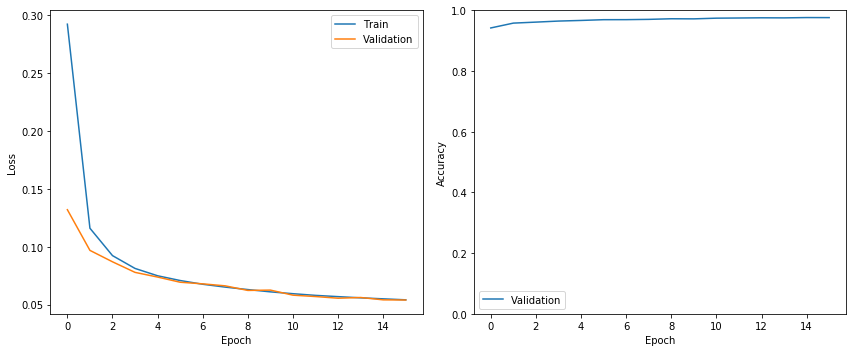

In [22]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, top=1)
ax1.legend(loc=0)

plt.tight_layout()

## Load the trained model

In [12]:
model = load_model(config, reload_epoch=15).eval()

loading model


## Load the test data set

In [13]:
n_test = 16

In [14]:
full_dataset = HitGraphDataset(get_input_dir(config))

# Take the test set from the back
test_indices = len(full_dataset) - 1 - torch.arange(n_test)
test_dataset = Subset(full_dataset, test_indices)

In [15]:
# Construct a data loaer
test_loader = DataLoader(test_dataset, collate_fn=collate_fn)

## Evaluate the model on the test dataset

In [16]:
%%time

with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in test_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)

CPU times: user 27.6 s, sys: 2.36 s, total: 30 s
Wall time: 7.74 s


In [17]:
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9766
Precision: 0.9471
Recall:    0.9533


In [18]:
# ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

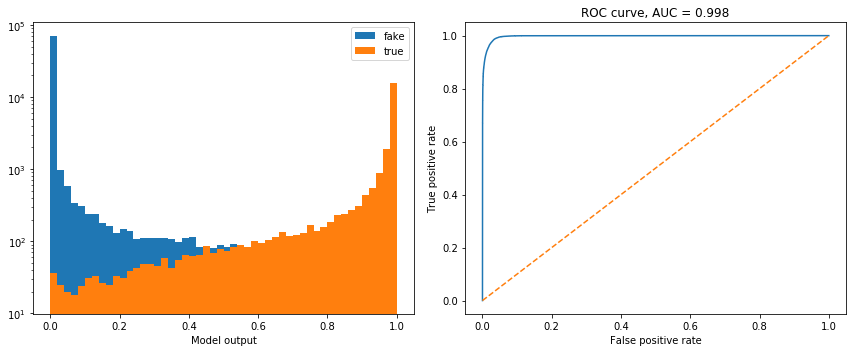

In [19]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

## Visualize predictions

In [20]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=True, figsize=(15, 7)):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$')
    ax1.set_xlabel('$\phi$')
    ax0.set_ylabel('$r$')
    ax1.set_ylabel('$r$')
    plt.tight_layout()

In [ ]:
%%time

n_draw = 4
for i in range(n_draw):
    X, Ri, Ro, y = test_dataset[i]
    pred = test_outputs[i][0].numpy()
    draw_sample(X, Ri, Ro, pred, alpha_labels=True)

CPU times: user 1min 6s, sys: 543 ms, total: 1min 7s
Wall time: 1min 7s


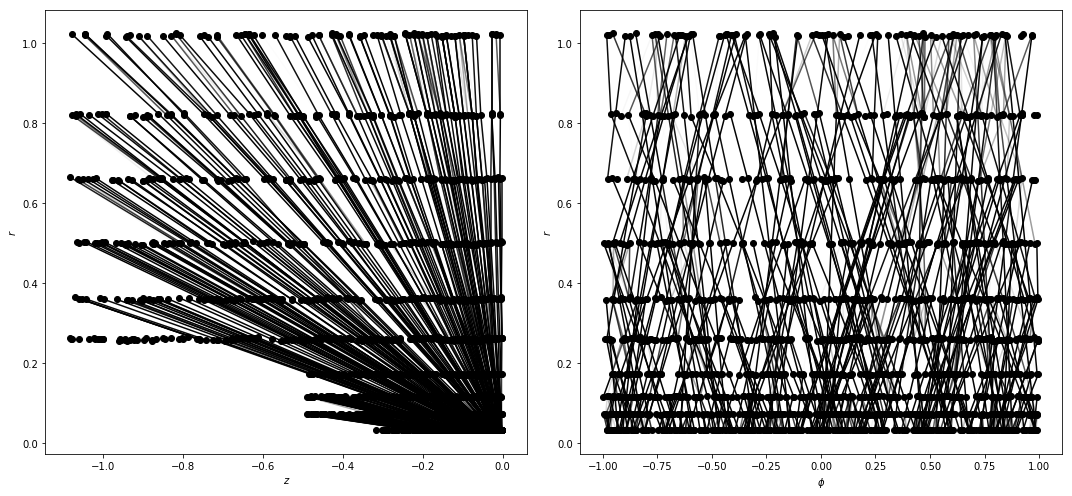

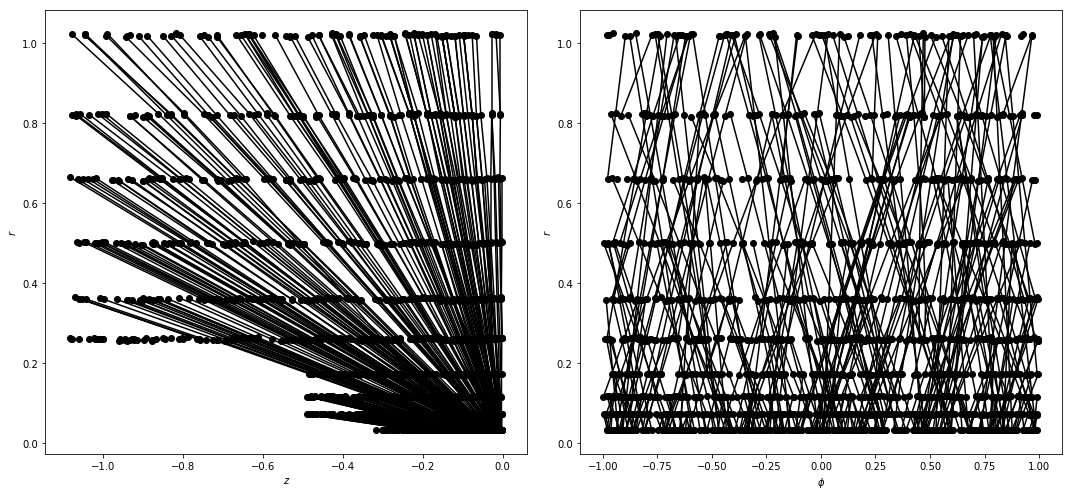

In [21]:
%%time

n_draw = 1
for i in range(n_draw):
    X, Ri, Ro, y = test_dataset[i]
    pred = test_outputs[i][0].numpy()
    draw_sample(X, Ri, Ro, pred)
    draw_sample(X, Ri, Ro, y)